In [502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Seaborn styling
sns.set(
    font="ABC Sans Nova",
    font_scale=2
)
sns.set_palette(["#037cc2", "#cc4e00"])

# salary data from APSC
pay_data = pd.read_excel(
    "./APS Agency Pay Scales - 31 December 2022.xlsx",
    skiprows=2,
    skipfooter=4,
    index_col=1
).iloc[:, 1:]

# extract APS job levels
levels = list(set([col.split(" ")[0] for col in pay_data.columns]))
levels.sort()

# staff headcounts from APSC
staff_data = pd.read_excel(
    "./Employment Data Release December 2022 - tables.xlsx",
    sheet_name=10,
    header=[2, 3],
    index_col=0,
    na_values=".",
    skipfooter=3
).iloc[:, 2:-7]
staff_data.fillna(0, inplace=True) # replace null values with zeros

# reclassify graduates as APS3s (to match pay data)
staff_data[("APS 3", "Men")] = staff_data[("APS 3", "Men")] + staff_data[("Graduate", "Men")]
staff_data[("APS 3", "Women")] = staff_data[("APS 3", "Women")] + staff_data[("Graduate", "Women")]
staff_data = staff_data.iloc[:, 2:]
staff_data.index = [  # clean up agency names
    "Attorney-General's Department"
    if name == "Attorney-General's"
    else "Department of the Prime Minister & Cabinet"
    if name == "Prime Minister and Cabinet"
    else "Treasury"
    if name == "Treasury"
    else name.replace(" and ", " & ").replace("- ", "")
    if "- " in name
    else "Department of " + name.replace(" and ", " & ")
    for name in staff_data.index
]

staff_data.columns = [ # tidy up column names
    (levels[i // 2], ["men", "women"][i % 2])
    for i in range(len(levels) * 2)
]

# keys used to match agencies
keys = pd.read_csv(
    "./agencyKeys.csv",
    index_col=0
)

# create combined dataset for analysis
data = pd.DataFrame(
    columns=["agency", "job level", "staff", "% female", "min. salary", "max. salary"]    
)

for key in pay_data.index:    
    agency = keys.at[key, "agency"]
    if agency in staff_data.index: # filter out agencies that lack staff data
        for level in levels:
            no_men = staff_data.at[agency, (level, "men")]
            no_women = staff_data.at[agency, (level, "women")]
            if no_men + no_women > 0: # filter out null results
                data.loc[len(data)] = [
                    agency,
                    level,                    
                    no_men + no_women,
                    no_women / (no_men + no_women),
                    pay_data.at[key, level + " Min"],
                    pay_data.at[key, level + " Max"]
                ]

# convert 'staff' into a radius measure, so scatterplots reflect agency size
data["chart size"] = np.sqrt(data.staff / np.pi)

data.to_csv("./apsGenderAnalysis.csv", index=False)

C:\Users\mannheimm6l\AppData\Local\Temp\1\ipykernel_9412\948150295.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=data.groupby("job level").sum().reset_index(),


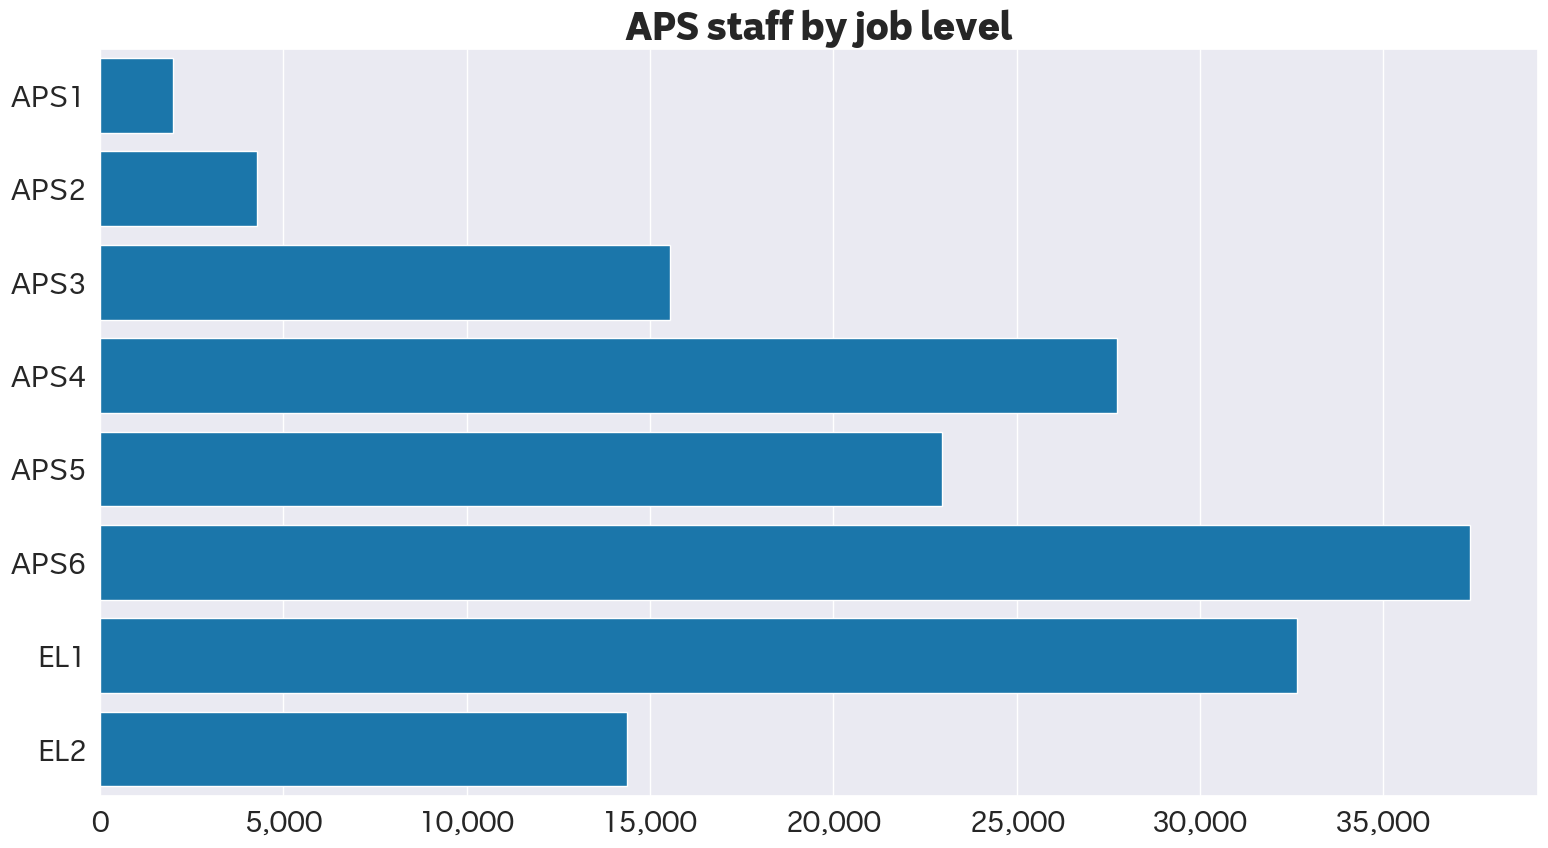

In [503]:
# APS staff by job level

fig = plt.figure(
    figsize=(16, 9),
    tight_layout=True
)

ax = sns.barplot(
    data=data.groupby("job level").sum().reset_index(),
    x="staff",
    y="job level",
    color=sns.color_palette()[0]
)

plt.title("APS staff by job level", fontweight="black", fontsize="large")
plt.xlabel(None)
plt.ylabel(None)
ax.xaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
plt.savefig("./staff_levels.png")

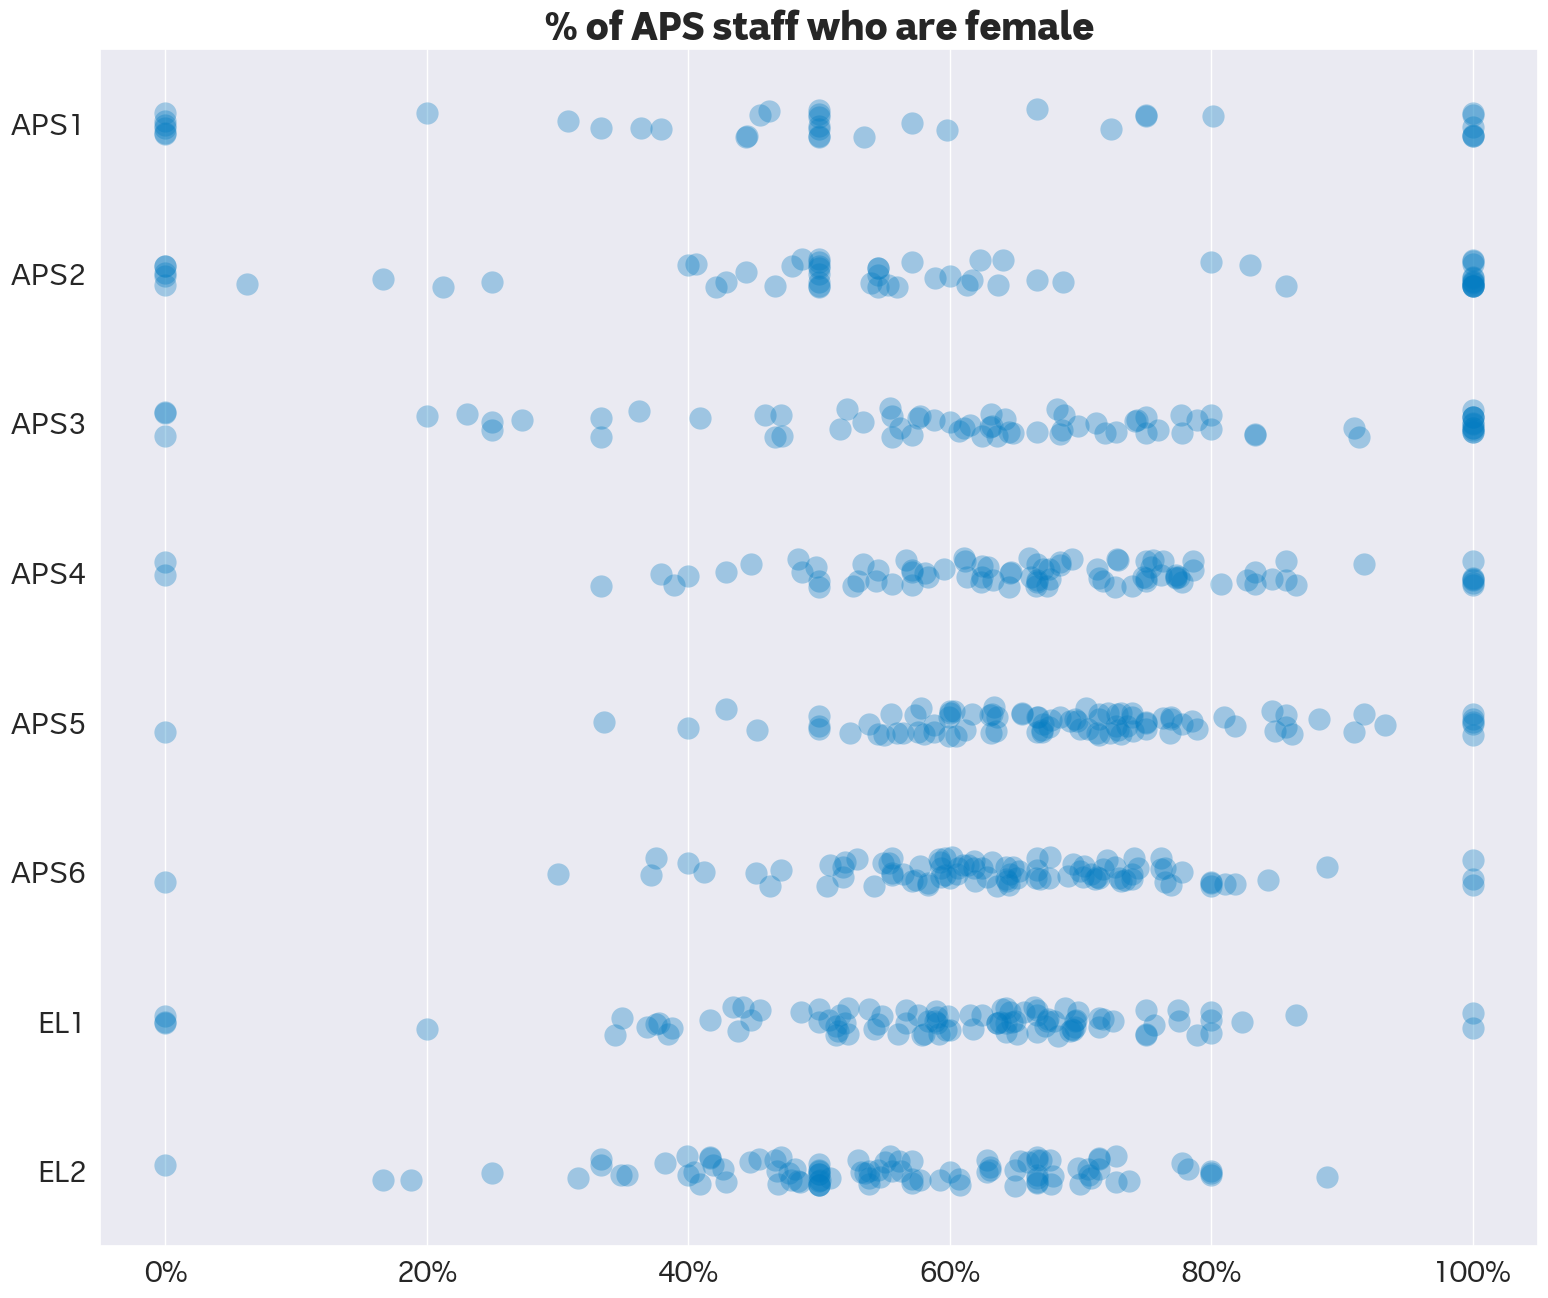

In [504]:
# Percentage of staff who are female

fig = plt.figure(
    figsize=(16, 13.5),
    tight_layout=True
)

ax = sns.stripplot(
    data=data,
    x="% female",
    y="job level",
    alpha=.33,
    s=16
)

plt.title("% of APS staff who are female", fontweight="black", fontsize="large")
plt.xlabel(None)
plt.ylabel(None)
ax.xaxis.set_major_formatter(lambda x, p: f"{x:,.0%}")
plt.savefig("./female_staff.png")

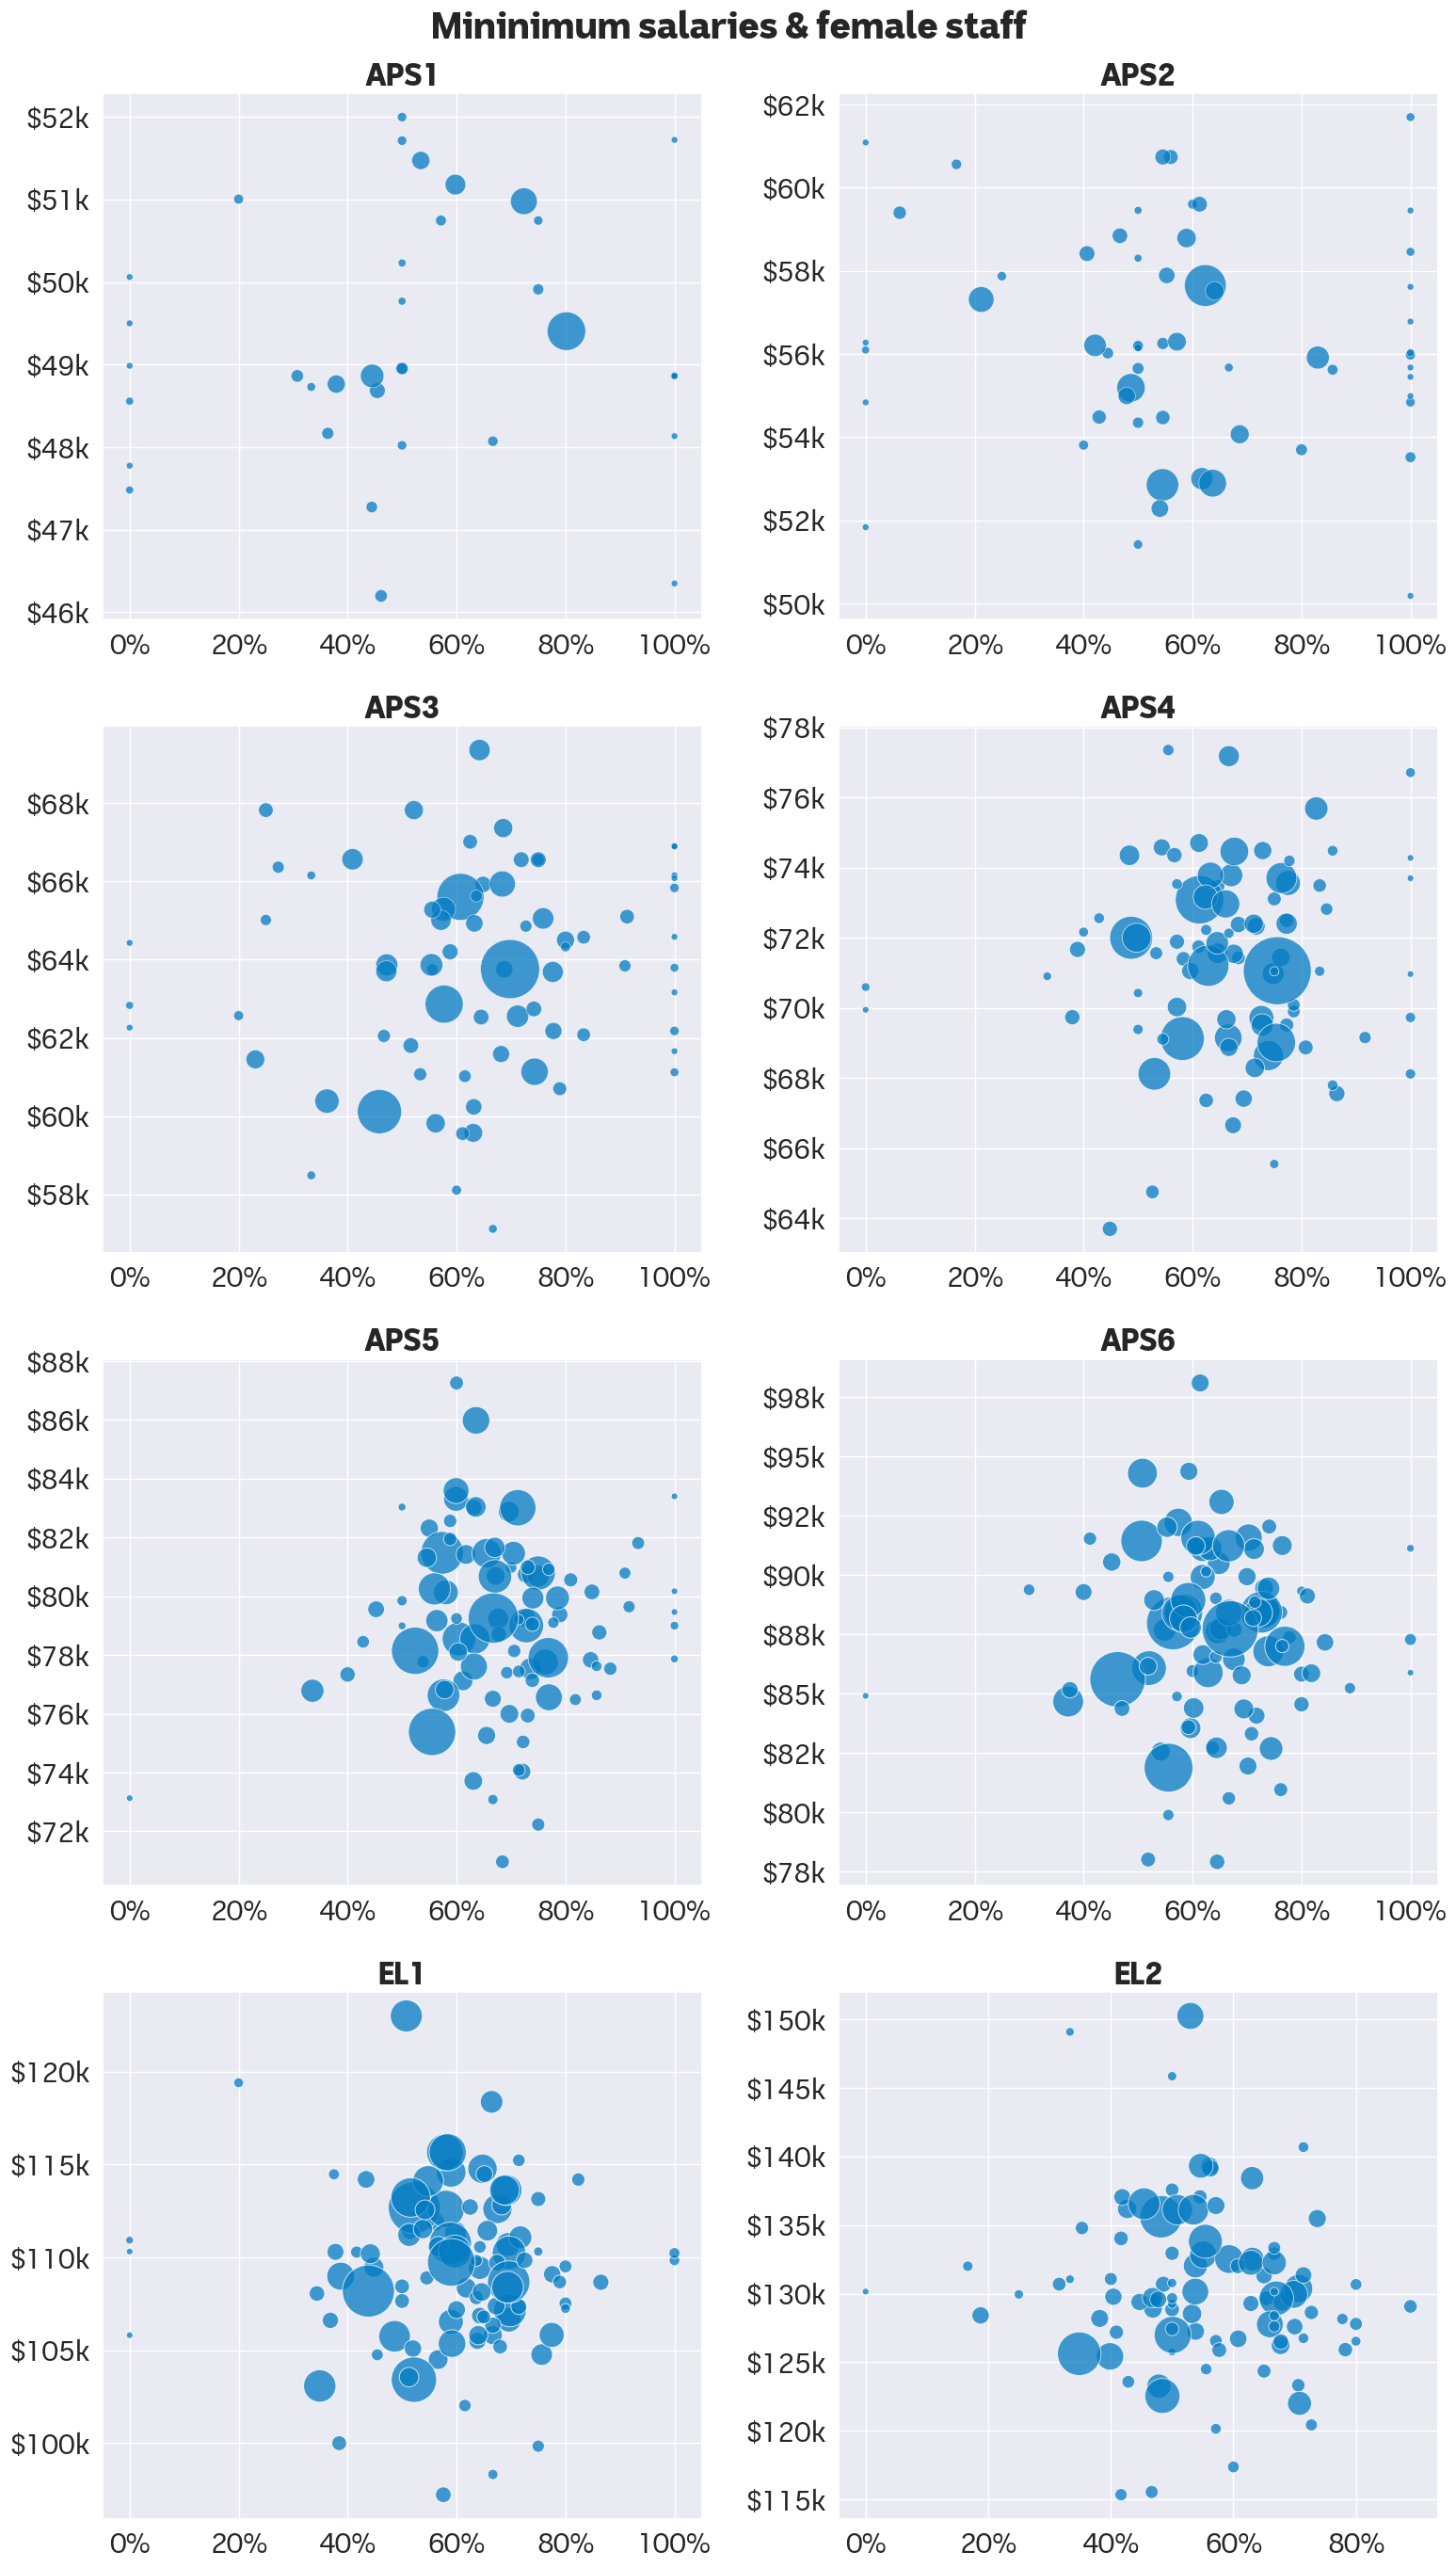

In [505]:
# Scatterplots showing minimum salary by % staff who are female

fig, ax = plt.subplots(
    4, 2,
    figsize=(16, 28),
    tight_layout=True
)

for i, level in enumerate(levels):

    plot_data = data[data["job level"] == level]

    sns.scatterplot(
        data=plot_data,
        x="% female",
        y="min. salary",
        alpha=.75,
        s=plot_data["chart size"] / plot_data["chart size"].min() * 25,
        ax=ax[i // 2, i % 2]
    )
    ax[i // 2, i % 2].xaxis.set_major_formatter(lambda x, p: f"{x:.0%}")
    ax[i // 2, i % 2].yaxis.set_major_formatter(lambda x, p: f"${x/1000:,.0f}k")
    ax[i // 2, i % 2].set_xlabel(None)
    ax[i // 2, i % 2].set_ylabel(None)
    ax[i // 2, i % 2].set_title(level, fontweight="black")

plt.suptitle("Mininimum salaries & female staff", fontweight="black", fontsize="large")

plt.savefig("./salary_levels.png")

In [512]:
# prepare linear regression: % female staff to predict salary
regression_results = pd.DataFrame(
    columns=["R squared (min. salary)", "R squared (max. salary)"]
)
regression_results.index.name = "job level"

# test at each job level
for level in levels:
    model_data = data[data["job level"] == level]

    # test min. salary
    X = model_data[["% female"]] # independent variable
    y = model_data["min. salary"] # dependent variable
   
    reg = LinearRegression().fit(X, y)
    regression_results.at[level, "R squared (min. salary)"] = f"{reg.score(X, y):.1%}"

    # test min. salary
    X = model_data[["% female"]] # independent variable
    y = model_data["max. salary"] # dependent variable
   
    reg = LinearRegression().fit(X, y)
    regression_results.at[level, "R squared (max. salary)"] = f"{reg.score(X, y):.1%}"

regression_results

,R squared (min. salary),R squared (max. salary)
job level,,
APS1,0.8%,0.1%
APS2,1.0%,1.8%
APS3,1.2%,0.1%
APS4,0.8%,0.0%
APS5,0.5%,0.1%
APS6,0.0%,1.5%
EL1,0.1%,0.0%
EL2,1.2%,0.4%


In [513]:
# prepare linear regressions weighted for agency size
regression_results = pd.DataFrame(
    columns=["R squared (min. salary)", "R squared (max. salary)"]
)
regression_results.index.name = "job level"

# test at each job level
for level in levels:
    model_data = data[data["job level"] == level]

    # test min. salary
    X = model_data[["% female"]] # independent variable
    y = model_data["min. salary"] # dependent variable
    weights = model_data.staff
   
    reg = LinearRegression().fit(X, y, weights)
    regression_results.at[level, "R squared (min. salary)"] = f"{reg.score(X, y):.1%}"

    # test min. salary
    X = model_data[["% female"]] # independent variable
    y = model_data["max. salary"] # dependent variable
    weights = model_data.staff
   
    reg = LinearRegression().fit(X, y, weights)
    regression_results.at[level, "R squared (max. salary)"] = f"{reg.score(X, y):.1%}"

regression_results

,R squared (min. salary),R squared (max. salary)
job level,,
APS1,-2.5%,-41.7%
APS2,-0.7%,-15.5%
APS3,-40.0%,-29.2%
APS4,-2.1%,-10.2%
APS5,-7.0%,-4.1%
APS6,-5.6%,-4.1%
EL1,-13.4%,-3.1%
EL2,-12.1%,-5.4%
